In [7]:
from pathlib import Path
import pandas as pd

from helpers.benchmark import load_records_from_directory

WEEK_EXPERIMENT_ROOT = "data/stage_c"
PARQUET_CACHE = "cache/stage_c.parquet"

cache_path = Path(PARQUET_CACHE)

if cache_path.exists():
    print(f"Loading cached dataframe from {cache_path} ...")
    df = pd.read_parquet(cache_path)
else:
    print("Cache not found – loading from raw directory ...")
    df = load_records_from_directory(WEEK_EXPERIMENT_ROOT)
    print(f"Loaded {len(df)} total records from Stage C experiments.")
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(cache_path, index=False)
    print(f"Wrote cache to {cache_path}")

# Ensure timestamp is UTC-aware
df = df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

# --- (Optional, recommended) hard UTC window first: keeps data volume sane ---
UTC_WEEK_START = pd.Timestamp("2025-12-01", tz="UTC")
UTC_WEEK_END   = pd.Timestamp("2025-12-08", tz="UTC")  # exclusive
df_utcweek = df[(df["timestamp"] >= UTC_WEEK_START) & (df["timestamp"] < UTC_WEEK_END)].copy()

# --- Provider-aware LOCAL-week filter (prevents "Sun 30" for AWS-style plots) ---
LOCAL_WEEK_START = "2025-12-01"
LOCAL_WEEK_END   = "2025-12-08"  # exclusive

df_us_east_local = df_utcweek[
    (df_utcweek["provider"].isin(["aws", "gcp", "alibaba"])) &
    (df_utcweek["timestamp"].dt.tz_convert("America/New_York") >= pd.Timestamp(LOCAL_WEEK_START, tz="America/New_York")) &
    (df_utcweek["timestamp"].dt.tz_convert("America/New_York") <  pd.Timestamp(LOCAL_WEEK_END,   tz="America/New_York"))
].copy()

df_berlin_local = df_utcweek[
    (df_utcweek["provider"] == "azure") &
    (df_utcweek["timestamp"].dt.tz_convert("Europe/Berlin") >= pd.Timestamp(LOCAL_WEEK_START, tz="Europe/Berlin")) &
    (df_utcweek["timestamp"].dt.tz_convert("Europe/Berlin") <  pd.Timestamp(LOCAL_WEEK_END,   tz="Europe/Berlin"))
].copy()

df = pd.concat([df_us_east_local, df_berlin_local], ignore_index=True)

print("Rows total:", len(df))
print("Rows after UTC week filter:", len(df_utcweek))
print("Rows after LOCAL week filter (provider-aware):", len(df))

Loading cached dataframe from cache/stage_c.parquet ...
Rows total: 1375300
Rows after UTC week filter: 1392583
Rows after LOCAL week filter (provider-aware): 1375300


In [8]:
from helpers.alibaba import load_all_billed_alibaba, inject_billed_alibaba
from helpers.azure import load_all_billed_azure, inject_billed_azure
from helpers.aws import load_all_billed_aws, inject_billed_aws
from helpers.gcp import load_all_billed_gcp, inject_billed_gcp



# ----- add billed duration from cloud providers -----
billed_alibaba_df = load_all_billed_alibaba(f"data/stage_c/billed/alibaba")
df = inject_billed_alibaba(df, billed_alibaba_df)

billed_azure_df = load_all_billed_azure(f"data/stage_c/billed/azure")
df = inject_billed_azure(df, billed_azure_df)

billed_aws_df = load_all_billed_aws(f"data/stage_c/billed/aws")
df = inject_billed_aws(df, billed_aws_df)

billed_gcp_df = load_all_billed_gcp(f"data/stage_c/billed/gcp")
df = inject_billed_gcp(df, billed_gcp_df)


📥 Loaded 514007 billed Alibaba records from 5 files.
✅ All Alibaba entries matched billed durations.
📥 Loaded 485673 billed Azure records from 5 files.
⚠️ 10 Azure entries have no billed duration match.
📥 Loaded 449996 billed AWS records from 45 files.
⚠️ 4 AWS entries have no billed duration match.
📥 Loaded 450000 billed GCP records from 45 files.
✅ All GCP entries matched billed durations.


💾 Saved to: ../holy/graphs/StageC/aws/cpu_composition/cpu_composition_over_time_aws_512mb.pdf


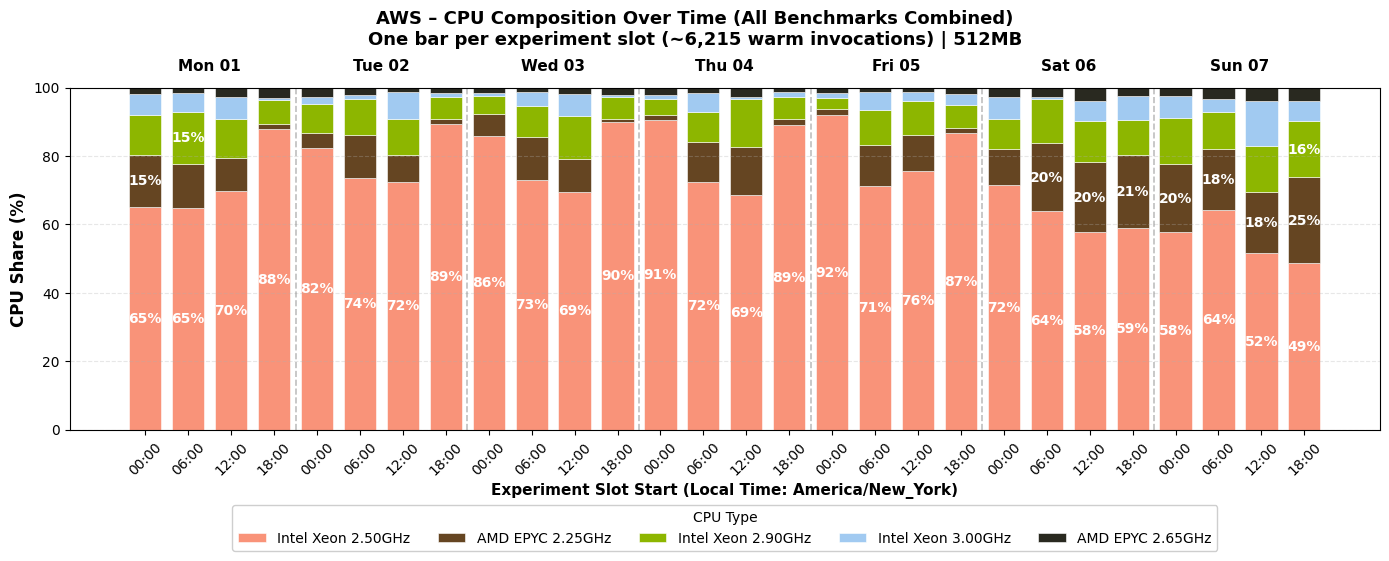

💾 Saved to: ../holy/graphs/StageC/azure/cpu_composition/cpu_composition_over_time_azure_512mb.pdf


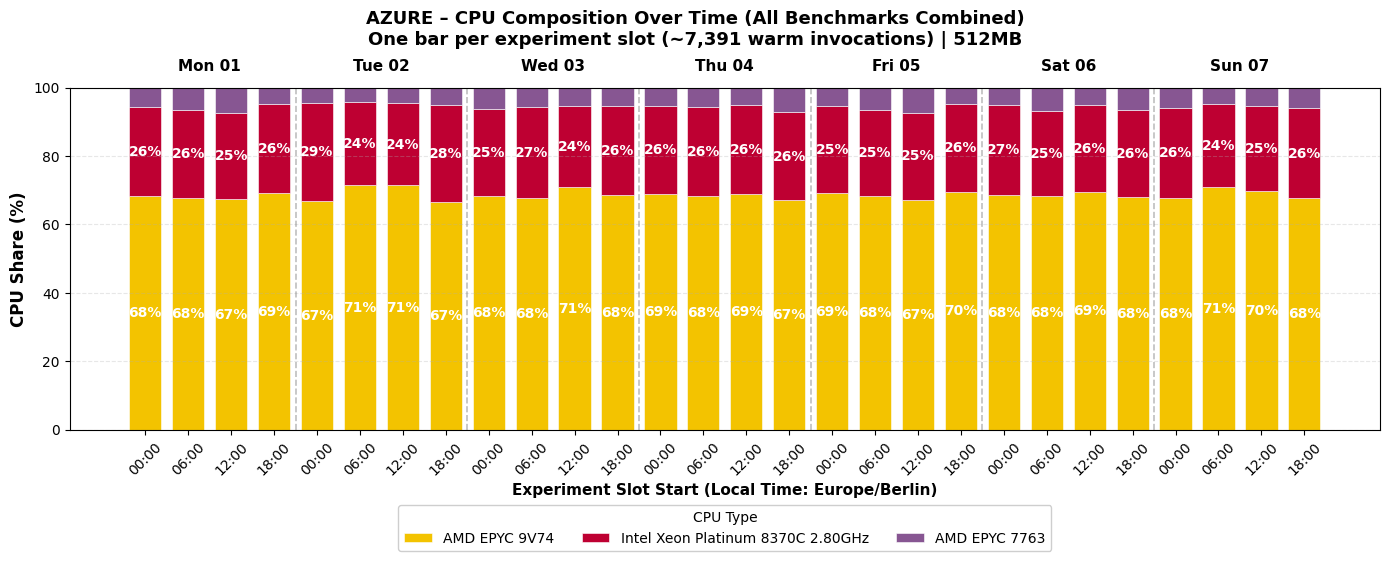

💾 Saved to: ../holy/graphs/StageC/gcp/cpu_composition/cpu_composition_over_time_gcp_512mb.pdf


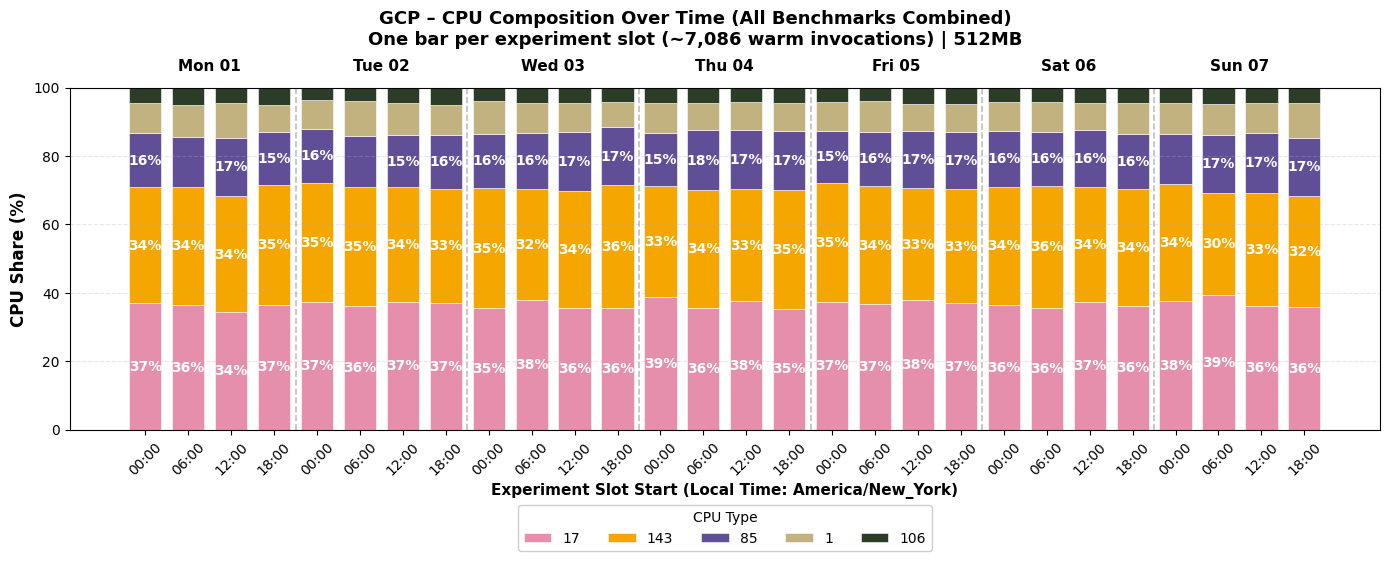

💾 Saved to: ../holy/graphs/StageC/alibaba/cpu_composition/cpu_composition_over_time_alibaba_512mb.pdf


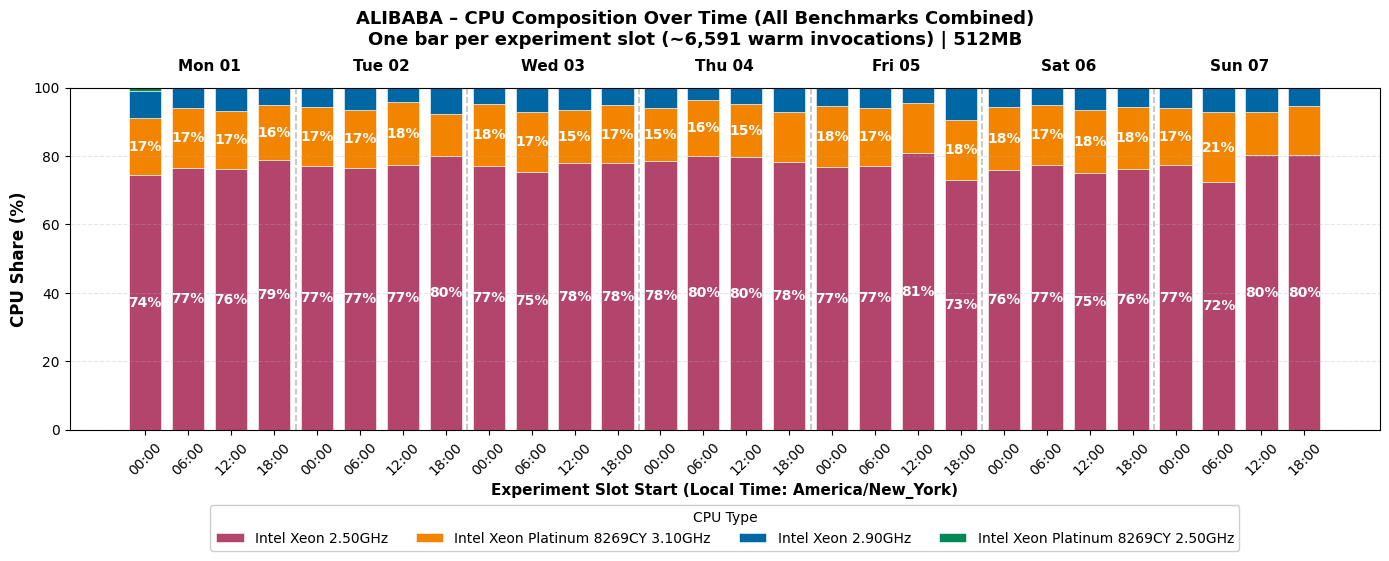

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from helpers.cpus import shorten_cpu_name, get_cpu_palette
from helpers.benchmark import filter_cpu_data


def _slot_bin_stage_c_utc(ts: pd.Series) -> pd.Series:
    """
    Stage C slots are at 23, 05, 11, 17 UTC (every 6h, offset -1h).
    This bins ANY timestamp into the correct slot even if benchmarks run sequentially within the slot.
    """
    ts = pd.to_datetime(ts, utc=True)
    return (ts + pd.Timedelta(hours=1)).dt.floor("6h") - pd.Timedelta(hours=1)


def _provider_local_tz(provider: str) -> str:
    # You requested "real location time"
    # AWS/GCP/Alibaba = us-east, Azure = Germany West Central.
    return "Europe/Berlin" if provider == "azure" else "America/New_York"


def plot_cpu_composition_over_time(
    df: pd.DataFrame,
    provider: str,
    memory_size: int = 512,
    benchmarks: list[str] | None = None,
    save_dir: str = "../holy/graphs/StageC",
):
    """
    One stacked bar per Stage C experiment slot (ALL benchmarks combined into that slot).
    X-axis labels are LOCAL TIMES for the provider location:
      - aws/gcp/alibaba -> America/New_York
      - azure          -> Europe/Berlin
    """

    if benchmarks is None:
        benchmarks = ["gemm", "sha256", "gzip", "aesCtr", "json"]

    # --- Collect filtered rows across benchmarks (warm-only + outliers removed by your helper) ---
    parts = []
    for bench in benchmarks:
        part = filter_cpu_data(
            df=df,
            provider=provider,
            memory_size=memory_size,
            benchmark=bench,
            group_on_timestamp=True,  # keep your intent
            remove_cold=True,
            region=None        )
        if not part.empty:
            parts.append(part)

    if not parts:
        print(f"❌ No data found for {provider} {memory_size}MB")
        return

    combined_df = pd.concat(parts, ignore_index=True)

    # Ensure timestamp is tz-aware UTC
    combined_df["timestamp"] = pd.to_datetime(combined_df["timestamp"], utc=True)

    # --- Bin to Stage C slot in UTC (23/05/11/17) ---
    combined_df["slot_utc"] = _slot_bin_stage_c_utc(combined_df["timestamp"])

    # --- Convert slot label to LOCAL TIME for display ---
    tz = _provider_local_tz(provider)
    combined_df["slot_local"] = combined_df["slot_utc"].dt.tz_convert(tz)

    # Sort by slot
    combined_df = combined_df.sort_values("slot_utc")

    # Unique slots and index mapping
    unique_slots_utc = sorted(combined_df["slot_utc"].unique())
    slot_to_idx = {slot: i for i, slot in enumerate(unique_slots_utc)}
    combined_df["slot_idx"] = combined_df["slot_utc"].map(slot_to_idx)

    # --- CPU distribution per slot (counts -> pct) ---
    dist_counts = (
        combined_df.groupby(["slot_idx", "cpu_type"])
        .size()
        .unstack(fill_value=0)
    )
    dist_pct = dist_counts.div(dist_counts.sum(axis=1), axis=0) * 100.0

    # Stable CPU order: by overall share (descending)
    cpu_order = dist_counts.sum(axis=0).sort_values(ascending=False).index.tolist()
    dist_pct = dist_pct.reindex(columns=cpu_order)

    palette = get_cpu_palette(cpu_order, provider=provider)

    # --- Day boundaries based on LOCAL time (for separators/labels) ---
    idx_to_local = {
        slot_to_idx[s]: pd.Timestamp(s).tz_convert(tz) for s in unique_slots_utc
    }
    local_dates = pd.Series([idx_to_local[i].date() for i in range(len(unique_slots_utc))])

    day_boundaries = {}
    for i, d in enumerate(local_dates):
        day_boundaries.setdefault(d, []).append(i)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(14, 6))

    bottom = np.zeros(len(dist_pct))
    bar_width = 0.75

    for cpu in dist_pct.columns:
        heights = dist_pct[cpu].values
        ax.bar(
            dist_pct.index,
            heights,
            bottom=bottom,
            width=bar_width,
            color=palette.get(cpu, "#333333"),
            edgecolor="white",
            linewidth=0.4,
            label=shorten_cpu_name(cpu, 35),
        )

        # Percentage labels (only larger segments)
        for i, (h, b) in enumerate(zip(heights, bottom)):
            if h >= 15:
                ax.text(
                    i,
                    b + h / 2,
                    f"{h:.0f}%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="white",
                    fontsize=10,
                )

        bottom += heights

    ax.set_ylabel("CPU Share (%)", fontweight="bold", fontsize=12)
    ax.set_ylim(0, 100)

    # X-axis labels: local time (HH:MM), plus day indicator above
    x = np.arange(len(unique_slots_utc))
    time_labels = [idx_to_local[i].strftime("%H:%M") for i in x]
    ax.set_xticks(x)
    ax.set_xticklabels(time_labels, fontsize=10, rotation=45)
    ax.set_xlabel(f"Experiment Slot Start (Local Time: {tz})", fontweight="bold", fontsize=11)

    # Day separators + day labels
    sorted_days = sorted(day_boundaries.keys())
    for di, day in enumerate(sorted_days, start=1):
        indices = day_boundaries[day]
        center = (indices[0] + indices[-1]) / 2

        ax.text(
            center, 104, f"{pd.Timestamp(day).strftime('%a %d')}",
            ha="center", va="bottom",
            fontsize=11, fontweight="bold",
        )

        if indices[0] > 0:
            ax.axvline(indices[0] - 0.5, color="gray", linestyle="--", linewidth=1.2, alpha=0.5)

    ax.grid(True, axis="y", linestyle="--", alpha=0.3)

    # Legend below
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.20),
        ncol=min(5, len(cpu_order)),
        fontsize=10,
        framealpha=0.95,
        title="CPU Type",
        title_fontsize=10,
    )

    # Title
    inv_per_slot = int(len(combined_df) // max(1, len(unique_slots_utc)))
    fig.suptitle(
        f"{provider.upper()} – CPU Composition Over Time (All Benchmarks Combined)\n"
        f"One bar per experiment slot (~{inv_per_slot:,} warm invocations) | {memory_size}MB",
        fontsize=13, fontweight="bold", y=0.98
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.28)

    # Save
    if save_dir:
        out_dir = os.path.join(save_dir, provider, "cpu_composition")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, f"cpu_composition_over_time_{provider}_{memory_size}mb.pdf")
        plt.savefig(out_path, bbox_inches="tight", format="pdf")
        print(f"💾 Saved to: {out_path}")

    plt.show()


# --- Run for all providers ---
plot_cpu_composition_over_time(df, "aws", memory_size=512)
plot_cpu_composition_over_time(df, "azure", memory_size=512)
plot_cpu_composition_over_time(df, "gcp", memory_size=512)
plot_cpu_composition_over_time(df, "alibaba", memory_size=512)


Running Decomposition...
  Processing gemm...
  Processing sha256...
  Processing gzip...
  Processing aesCtr...
  Processing json...


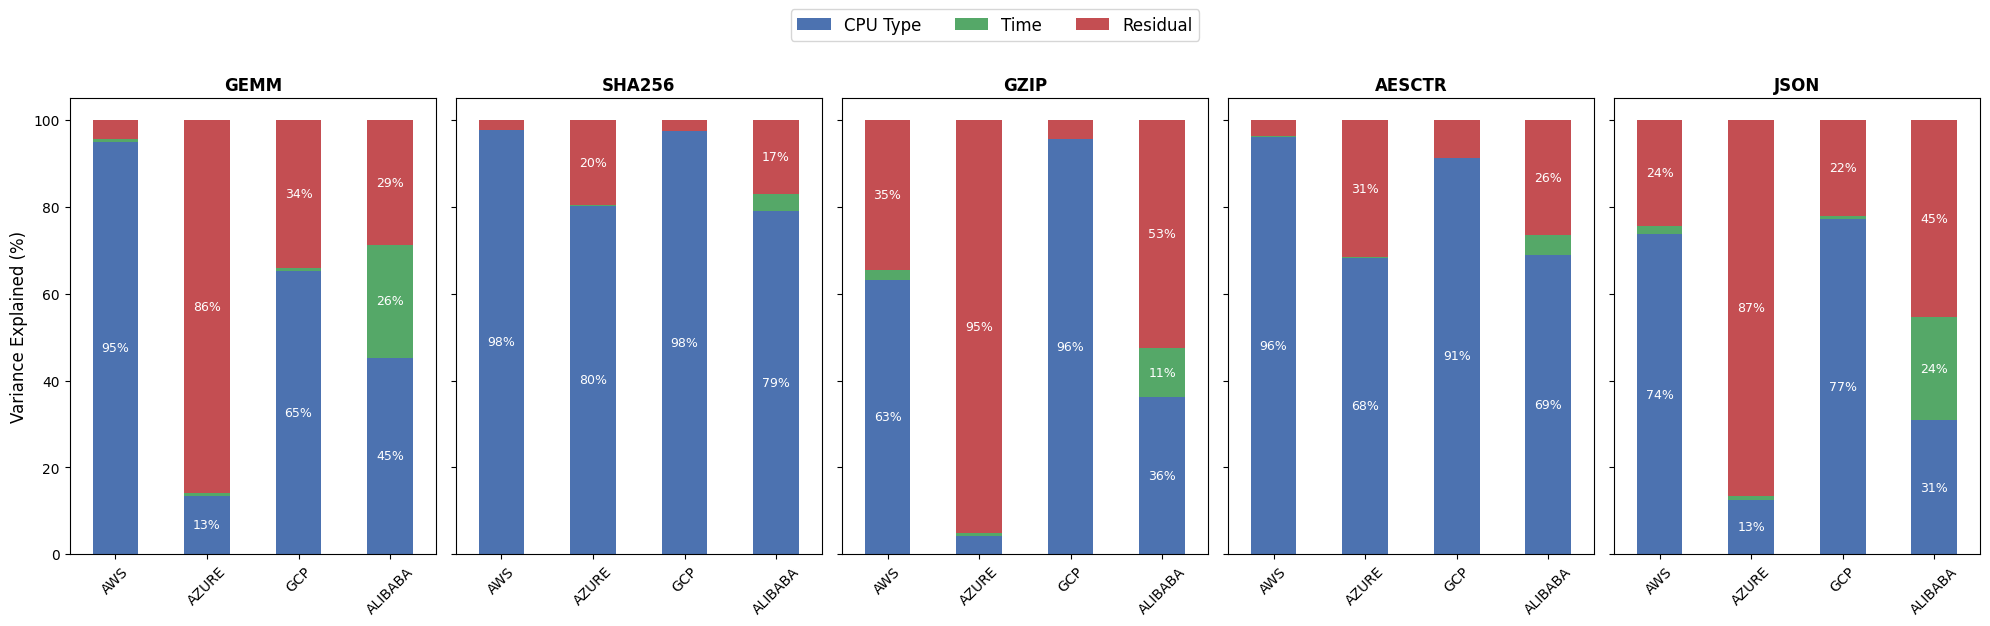

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

from helpers.benchmark import filter_cpu_data, metric_for_benchmark


# --- Stage C slot binning (23/05/11/17 UTC) ---
def _slot_bin_stage_c_utc(ts: pd.Series) -> pd.Series:
    """
    Stage C slots are at 23, 05, 11, 17 UTC (every 6h, offset -1h).
    This bins any timestamp into the correct slot even if benchmarks ran sequentially within the slot.
    """
    ts = pd.to_datetime(ts, utc=True)
    return (ts + pd.Timedelta(hours=1)).dt.floor("6h") - pd.Timedelta(hours=1)


def _provider_local_tz(provider: str) -> str:
    # Real location time:
    # aws/gcp/alibaba = us-east, azure = germany west central
    return "Europe/Berlin" if provider == "azure" else "America/New_York"


# --- 1. Data Preparation ---
def analyze_provider(provider: str, df: pd.DataFrame, benchmark_type: str) -> pd.DataFrame:
    memory_size = 512

    # Ensure timestamp is UTC-aware
    if not pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
        df = df.copy()
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    else:
        # If dtype is datetime but tz-naive, force UTC
        if getattr(df["timestamp"].dt, "tz", None) is None:
            df = df.copy()
            df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)

    # Use your centralized filtering (OUTLIER FILTER ACTIVE)
    df_filtered = filter_cpu_data(
        df=df,
        provider=provider,
        memory_size=memory_size,
        benchmark=benchmark_type,
        group_on_timestamp=False,
        region=None,
        remove_cold=True,
        no_outlier_filter=False,   # keep outlier filtering ON
    )

    if df_filtered.empty:
        return pd.DataFrame()

    metric = metric_for_benchmark(benchmark_type)
    if metric not in df_filtered.columns:
        return pd.DataFrame()

    # Aggregate to per-instance means (warm invocations only already)
    per_instance = (
        df_filtered
        .dropna(subset=["instance_id", "cpu_type", "timestamp", metric])
        .groupby(["instance_id", "cpu_type"], as_index=False)
        .agg({metric: "mean", "timestamp": "min"})
        .rename(columns={metric: "mean_benchmark_time_ms"})
    )

    if per_instance.empty:
        return per_instance

    # Bin into the Stage C experiment slot, then convert to provider-local time for the factor
    tz = _provider_local_tz(provider)
    per_instance["time_bin"] = (
        _slot_bin_stage_c_utc(per_instance["timestamp"])
        .dt.tz_convert(tz)
        .astype(str)
    )

    return per_instance


# --- 2. Variance Decomposition ---
def get_variance_decomposition(df_in: pd.DataFrame):
    if df_in.empty or df_in["cpu_type"].nunique() < 2:
        return None

    # Need at least 2 time bins to estimate a time effect
    if df_in["time_bin"].nunique() < 2:
        return None

    try:
        model = ols("mean_benchmark_time_ms ~ C(cpu_type) + C(time_bin)", data=df_in).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)

        ss_total = anova_table["sum_sq"].sum()
        if ss_total == 0:
            return None

        results = {
            "CPU Type": (anova_table.loc["C(cpu_type)", "sum_sq"] / ss_total) * 100
        }

        if "C(time_bin)" in anova_table.index:
            results["Time"] = (anova_table.loc["C(time_bin)", "sum_sq"] / ss_total) * 100
        else:
            results["Time"] = 0.0

        results["Residual"] = (anova_table.loc["Residual", "sum_sq"] / ss_total) * 100
        return results

    except Exception:
        return None


# --- 3. Execution Loop ---
benchmarks = ["gemm", "sha256", "gzip", "aesCtr", "json"]
providers = ["aws", "azure", "gcp", "alibaba"]

all_results = []

print("Running Decomposition...")
for bench in benchmarks:
    print(f"  Processing {bench}...")
    for provider in providers:
        df_prov = analyze_provider(provider, df, benchmark_type=bench)

        if not df_prov.empty:
            decomp = get_variance_decomposition(df_prov)
            if decomp:
                decomp["Provider"] = provider.upper()
                decomp["Benchmark"] = bench
                all_results.append(decomp)

# --- 4. Plotting ---
if all_results:
    full_df = pd.DataFrame(all_results)

    fig, axes = plt.subplots(nrows=1, ncols=len(benchmarks), figsize=(20, 6), sharey=True)

    colors = {"CPU Type": "#4c72b0", "Time": "#55a868", "Residual": "#c44e52"}

    for i, bench in enumerate(benchmarks):
        ax = axes[i]

        data = full_df[full_df["Benchmark"] == bench].set_index("Provider")
        plot_data = data[["CPU Type", "Time", "Residual"]]

        plot_data.plot(
            kind="bar",
            stacked=True,
            ax=ax,
            color=[colors[c] for c in plot_data.columns],
            legend=False
        )

        ax.set_title(bench.upper(), fontsize=12, fontweight="bold")
        ax.set_xlabel("")
        ax.tick_params(axis="x", rotation=45)

        for c in ax.containers:
            labels = [f"{v.get_height():.0f}%" if v.get_height() > 10 else "" for v in c]
            ax.bar_label(c, labels=labels, label_type="center", color="white", fontsize=9)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=12)

    axes[0].set_ylabel("Variance Explained (%)", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("No sufficient data found for decomposition.")



💾 Saved to: ../holy/graphs/StageC/aws/cpu_share/stage_c_cpu_share_aws_512mb.pdf


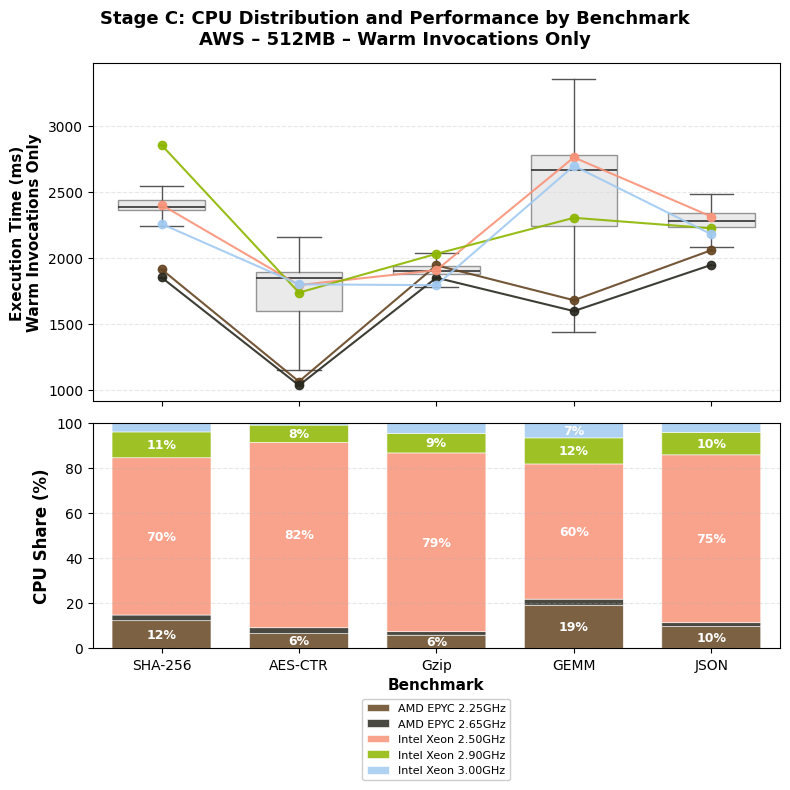


💾 Saved to: ../holy/graphs/StageC/azure/cpu_share/stage_c_cpu_share_azure_512mb.pdf


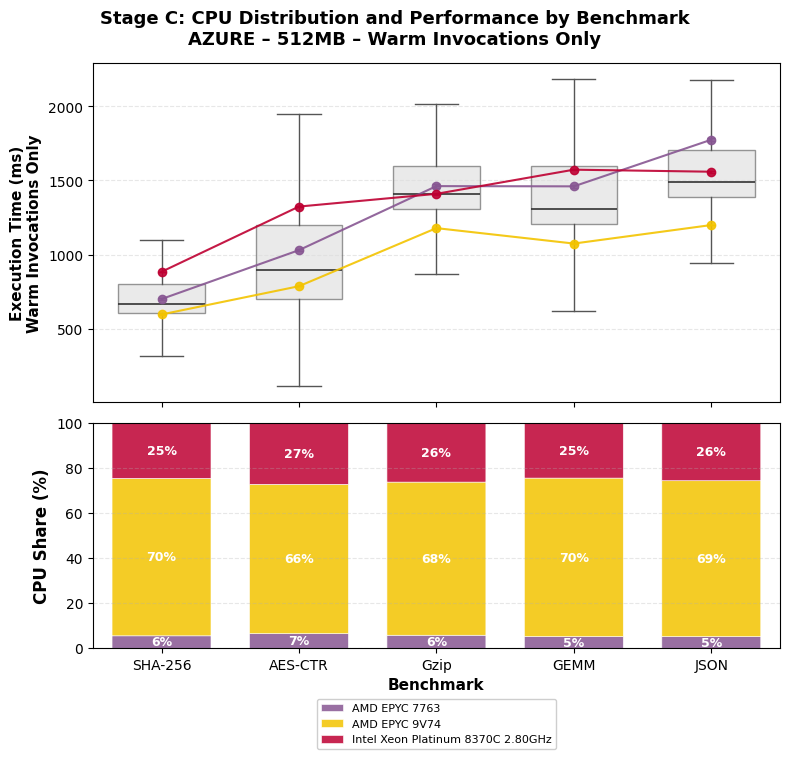


💾 Saved to: ../holy/graphs/StageC/gcp/cpu_share/stage_c_cpu_share_gcp_512mb.pdf


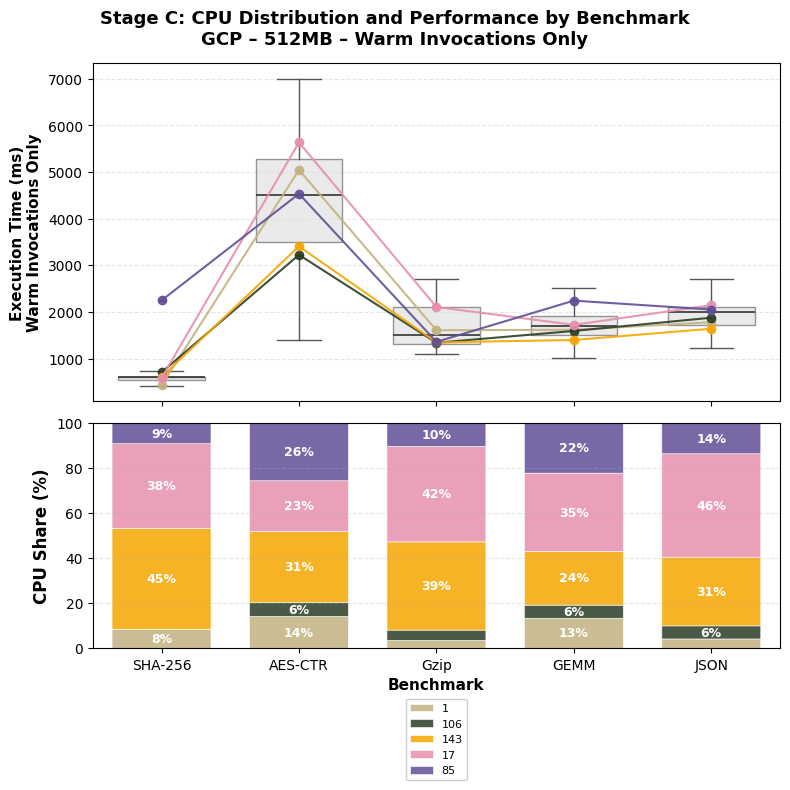


💾 Saved to: ../holy/graphs/StageC/alibaba/cpu_share/stage_c_cpu_share_alibaba_512mb.pdf


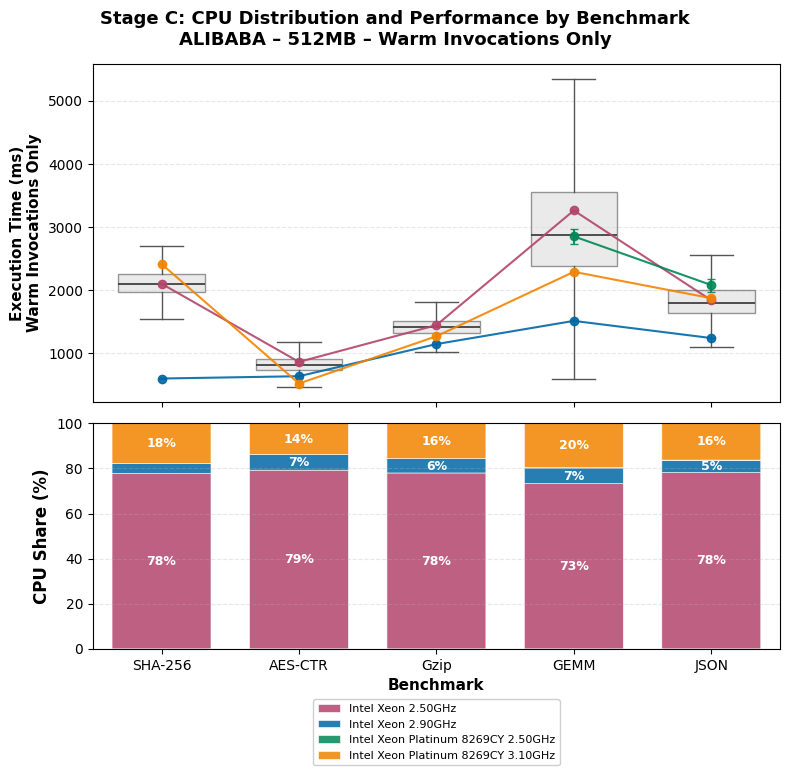

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import FancyBboxPatch
from helpers.cpus import shorten_cpu_name, get_cpu_palette
from helpers.benchmark import metric_for_benchmark
from helpers.benchmark import filter_cpu_data


def plot_stage_c_cpu_share(
    df,
    provider,
    memory_size=512,
    benchmarks=None,
    save_dir="../holy/graphs/StageC",
):
    """
    Stage C stacked bar + performance plot:
    - One provider
    - 512MB (by default)
    - X-axis: benchmark types (sha256, aesCtr, gzip, gemm, json)
    - Bottom subplot: CPU share (%) per benchmark (stacked bars)
    - Top subplot: per-CPU mean performance (points + error bars)
      + platform-wide distribution as a boxplot per benchmark
    """

    if benchmarks is None:
        benchmarks = ["sha256", "aesCtr", "gzip", "gemm", "json"]

    results = []
    used_benchmarks = []
    box_data = {}  # NEW: raw metric values per benchmark (for boxplots)

    # --- Collect data for CPU share + performance + boxplots ---
    for benchmark in benchmarks:
        df_filtered = filter_cpu_data(
            df, provider=provider, memory_size=memory_size, benchmark=benchmark, group_on_timestamp=True
        )

        if df_filtered.empty:
            print(f"⚠️  No data for {provider} {memory_size}MB – {benchmark}")
            continue

        used_benchmarks.append(benchmark)

        metric = metric_for_benchmark(benchmark)
        cpu_group = df_filtered.groupby("cpu_type")

        cpu_counts = cpu_group.size()
        total = cpu_counts.sum()

        stats = cpu_group[metric].agg(["mean", "sem", "count"])

        # Store all metric values for the platform-wide distribution
        box_data[benchmark] = df_filtered[metric].to_numpy()

        for cpu in stats.index:
            count = int(cpu_counts.loc[cpu])
            percentage = count / total * 100.0
            mean_ms = float(stats.loc[cpu, "mean"])
            sem_val = stats.loc[cpu, "sem"]
            sem_ms = float(sem_val) if not np.isnan(sem_val) else 0.0

            results.append(
                {
                    "provider": provider,
                    "benchmark": benchmark,
                    "cpu_type": cpu,
                    "memory_size": memory_size,
                    "count": count,
                    "percentage": percentage,
                    "mean_ms": mean_ms,
                    "sem_ms": sem_ms,
                }
            )

    if not results:
        print("❌ No data to plot for any benchmark")
        return

    results_df = pd.DataFrame(results)

    # Keep benchmark order in which we actually have data
    used_benchmarks = list(dict.fromkeys(used_benchmarks))

    provider_cpus = sorted(results_df["cpu_type"].unique())

    # Nice labels for the x-axis
    pretty_bench = {
        "sha256": "SHA-256",
        "aesCtr": "AES-CTR",
        "gzip": "Gzip",
        "gemm": "GEMM",
        "json": "JSON",
    }

    n_bench = len(used_benchmarks)
    x_positions = np.arange(n_bench)
    bar_width = 0.7

    # --- Build CPU share pivot: benchmark -> {cpu_type: percentage} ---
    share_pivot = {}
    for bench in used_benchmarks:
        bench_data = results_df[results_df["benchmark"] == bench]
        share_pivot[bench] = {
            row["cpu_type"]: row["percentage"]
            for _, row in bench_data.iterrows()
        }

    # --- Build performance pivot: mean + sem in ms ---
    perf_mean = (
        results_df.pivot_table(
            index="benchmark",
            columns="cpu_type",
            values="mean_ms",
            aggfunc="mean",
        )
        .reindex(used_benchmarks)
    )

    perf_sem = (
        results_df.pivot_table(
            index="benchmark",
            columns="cpu_type",
            values="sem_ms",
            aggfunc="mean",
        )
        .reindex(used_benchmarks)
    )

    # Provider-aware colors for CPUs
    palette = get_cpu_palette(provider_cpus, provider=provider)

    # --- Figure with two subplots: performance (top) + CPU share (bottom) ---
    fig, (ax_perf, ax_share) = plt.subplots(
        2,
        1,
        figsize=(8, 9),
        sharex=True,
        gridspec_kw={"height_ratios": [3, 2]},
    )

    # =========================
    # 1) PERFORMANCE PER CPU + BOX PLOTS
    # =========================

    # 1a) Platform-wide boxplots per benchmark
    box_values = [box_data[b] for b in used_benchmarks]
    bp = ax_perf.boxplot(
        box_values,
        positions=x_positions,
        widths=bar_width * 0.9,
        showfliers=False,
        patch_artist=True,
        manage_ticks=False,
    )

    # Style the boxplots a bit
    for box in bp["boxes"]:
        box.set_facecolor("#dddddd")
        box.set_alpha(0.6)
        box.set_edgecolor("#555555")
        box.set_linewidth(1.0)

    for median in bp["medians"]:
        median.set_color("#333333")
        median.set_linewidth(1.2)

    for whisker in bp["whiskers"]:
        whisker.set_color("#555555")
        whisker.set_linewidth(1.0)

    for cap in bp["caps"]:
        cap.set_color("#555555")
        cap.set_linewidth(1.0)

    # 1b) CPU-specific mean + SEM overlaid as points/lines
    for cpu in provider_cpus:
        if cpu not in perf_mean.columns:
            continue

        y = perf_mean[cpu].values
        yerr = perf_sem[cpu].values if cpu in perf_sem.columns else np.zeros_like(y)

        mask = ~np.isnan(y)
        if not np.any(mask):
            continue

        ax_perf.errorbar(
            x_positions[mask],
            y[mask],
            yerr=np.nan_to_num(yerr[mask]),
            marker="o",
            linestyle="-",
            linewidth=1.5,
            capsize=3,
            color=palette.get(cpu, "#333333"),
            alpha=0.9,
            zorder=3,  # on top of boxplots
        )

    ax_perf.set_ylabel(
        "Execution Time (ms)\nWarm Invocations Only",
        fontweight="bold",
        fontsize=11,
    )
    ax_perf.grid(True, axis="y", linestyle="--", alpha=0.3)

    # =========================
    # 2) CPU SHARE (STACKED)
    # =========================
    bottom_positions = np.zeros(n_bench)
    legend_entries = {}

    for cpu_name in provider_cpus:
        heights = [share_pivot[bench].get(cpu_name, 0.0) for bench in used_benchmarks]

        for i, height in enumerate(heights):
            if height <= 0:
                continue

            x_pos = x_positions[i] - bar_width / 2.0
            y_pos = bottom_positions[i]
            color = palette.get(cpu_name, "#333333")

            # Rounded stacked segment
            box = FancyBboxPatch(
                (x_pos, y_pos),
                bar_width,
                height,
                boxstyle="round,pad=0.01",
                edgecolor="white",
                facecolor=color,
                linewidth=0.5,
                alpha=0.85,
                transform=ax_share.transData,
            )
            ax_share.add_patch(box)

            # Percentage label inside segment (only if big enough)
            if height > 5:
                ax_share.text(
                    x_positions[i],
                    y_pos + height / 2.0,
                    f"{height:.0f}%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="white",
                    fontsize=9,
                )

            # One legend entry per CPU
            if cpu_name not in legend_entries:
                legend_entries[cpu_name] = (box, shorten_cpu_name(cpu_name, 35))

        bottom_positions += np.array(heights)

    ax_share.set_xticks(x_positions)
    ax_share.set_xticklabels(
        [pretty_bench.get(b, b) for b in used_benchmarks],
        fontsize=10,
    )
    ax_share.set_xlabel("Benchmark", fontweight="bold", fontsize=11)
    ax_share.set_ylabel("CPU Share (%)", fontweight="bold", fontsize=12)

    ax_share.set_ylim(0, 100)
    ax_share.set_xlim(-0.5, n_bench - 0.5)
    ax_share.grid(True, axis="y", linestyle="--", alpha=0.3)

    # --- Title ---
    fig.suptitle(
        f"Stage C: CPU Distribution and Performance by Benchmark\n"
        f"{provider.upper()} – {memory_size}MB – Warm Invocations Only",
        fontsize=13,
        fontweight="bold",
        y=0.96,
    )

    # --- Legend (CPU types) below the bottom subplot ---
    if legend_entries:
        handles = [entry[0] for entry in legend_entries.values()]
        labels = [entry[1] for entry in legend_entries.values()]
        ax_share.legend(
            handles,
            labels,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.20),
            framealpha=0.95,
            fontsize=8,
            ncol=1,
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.25)

    # --- Save next to your other Stage C graphs ---
    if save_dir:
        out_dir = os.path.join(save_dir, provider, "cpu_share")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(
            out_dir, f"stage_c_cpu_share_{provider}_{memory_size}mb.pdf"
        )
        plt.savefig(out_path, bbox_inches="tight", format="pdf")
        print(f"\n💾 Saved to: {out_path}")

    plt.show()


# Calls stay the same:
plot_stage_c_cpu_share(df, "aws", memory_size=512)
plot_stage_c_cpu_share(df, "azure", memory_size=512)
plot_stage_c_cpu_share(df, "gcp", memory_size=512)
plot_stage_c_cpu_share(df, "alibaba", memory_size=512)


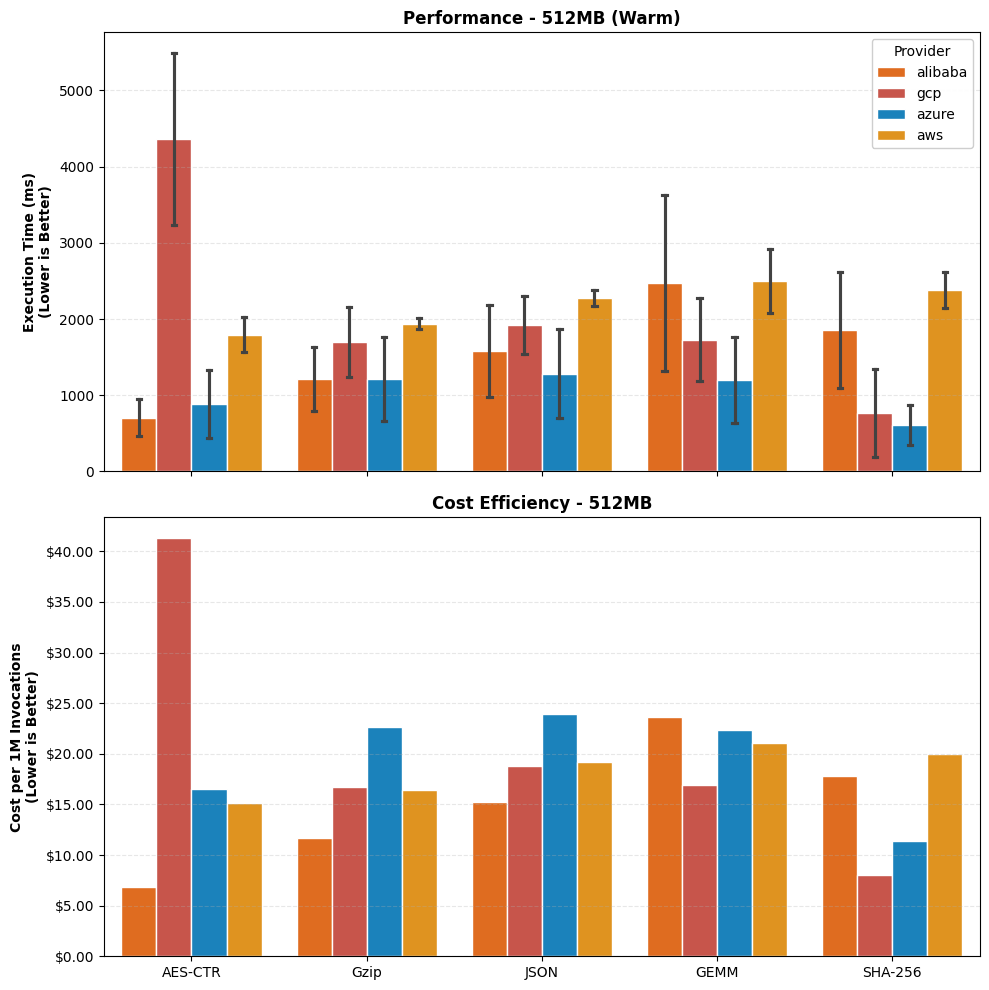

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
from helpers.benchmark import metric_for_benchmark 
from helpers.cost import calculate_cost

def plot_performance_and_cost(df, benchmarks=None, memory_size=512):
    if benchmarks is None:
        benchmarks = ["sha256", "aesCtr", "gzip", "gemm", "json"]
    
    # 1. Filter Data safely
    # Check if column is 'benchmark' or 'benchmark_type'
    bench_col = "benchmark_type" if "benchmark_type" in df.columns else "benchmark"
    
    subset = df[
        (df["memory_size_mb"] == memory_size) & 
        (df[bench_col].isin(benchmarks))
    ].copy()

    if subset.empty:
        print(f"⚠️ No data found for {memory_size}MB.")
        return

    # 2. Consolidate Duration (Handle different metric names)
    subset["duration_ms"] = np.nan
    for bench in benchmarks:
        metric_col = metric_for_benchmark(bench)
        mask = subset[bench_col] == bench
        if metric_col in subset.columns:
            subset.loc[mask, "duration_ms"] = subset.loc[mask, metric_col]
    
    # Drop rows where we couldn't find a duration
    subset = subset.dropna(subset=["duration_ms"])

    # 3. APPLY COST LOGIC (The new clean way)
    # We use a lambda to map the columns to our standalone function
    subset["cost_usd"] = subset.apply(
        lambda row: calculate_cost(
            provider=row["provider"],
            memory_mb=row["memory_size_mb"],
            duration_ms=row["duration_ms"]
        ), axis=1
    )
    
    # Calculate "Cost per 1 Million" for readability
    subset["cost_per_1m"] = subset["cost_usd"] * 1_000_000

    # 4. Plotting
    pretty_names = {
        "sha256": "SHA-256", "aesCtr": "AES-CTR", 
        "gzip": "Gzip", "gemm": "GEMM", "json": "JSON"
    }
    subset["Benchmark Name"] = subset[bench_col].map(pretty_names).fillna(subset[bench_col])
    
    provider_colors = {
        "aws": "#FF9900",      # AWS Orange
        "azure": "#0089D6",    # Azure Blue
        "gcp": "#DB4437",      # Google Red
        "alibaba": "#FF6600"   # Alibaba Orange (Adjusted)
    }

    fig, (ax_time, ax_cost) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Top Plot: Execution Time
    sns.barplot(
        data=subset, x="Benchmark Name", y="duration_ms", hue="provider",
        palette=provider_colors, errorbar="sd", capsize=0.1, ax=ax_time,
        edgecolor="white", linewidth=1
    )
    ax_time.set_ylabel("Execution Time (ms)\n(Lower is Better)", fontweight='bold')
    ax_time.set_title(f"Performance - {memory_size}MB (Warm)", fontweight='bold', fontsize=12)
    ax_time.grid(axis='y', linestyle='--', alpha=0.3)
    ax_time.legend(title="Provider", loc='upper right', framealpha=0.95)

    # Bottom Plot: Cost
    sns.barplot(
        data=subset, x="Benchmark Name", y="cost_per_1m", hue="provider",
        palette=provider_colors, errorbar=None, ax=ax_cost,
        edgecolor="white", linewidth=1
    )
    
    # Currency Formatting ($5.00)
    fmt = '${x:,.2f}'
    ax_cost.yaxis.set_major_formatter(mtick.StrMethodFormatter(fmt))
    
    ax_cost.set_ylabel("Cost per 1M Invocations\n(Lower is Better)", fontweight='bold')
    ax_cost.set_title(f"Cost Efficiency - {memory_size}MB", fontweight='bold', fontsize=12)
    ax_cost.grid(axis='y', linestyle='--', alpha=0.3)
    ax_cost.get_legend().remove() # Remove duplicate legend
    ax_cost.set_xlabel("")

    plt.tight_layout()
    plt.show()

# Example Usage:
# plot_performance_and_cost(df, memory_size=512)
# plot_performance_and_cost(df, memory_size=2048)
# Run the updated function
plot_performance_and_cost(df, memory_size=512)

<Axes: xlabel='multiplication_time_ms', ylabel='Proportion'>

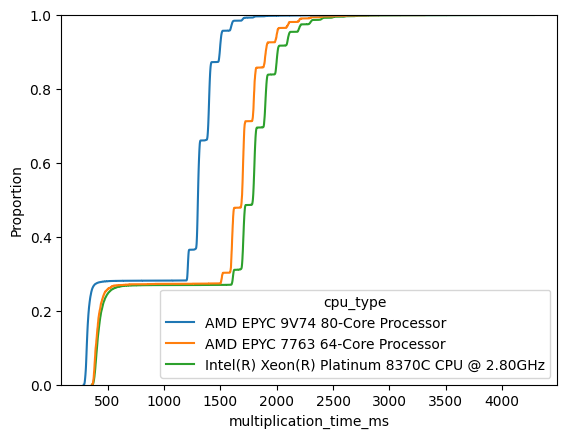

In [2]:
subset = df[(df["provider"] == "azure" ) & (df["memory_size_mb"] == 512) & (df["benchmark_type"] == "gemm")]


sns.ecdfplot(data=subset, x="multiplication_time_ms", hue="cpu_type")

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from helpers.benchmark import filter_cpu_data, metric_for_benchmark
from helpers.cpus import shorten_cpu_name, get_cpu_palette


def _slot_bin_stage_c_utc(ts: pd.Series) -> pd.Series:
    """
    Stage C slots are at 23, 05, 11, 17 UTC (every 6h, offset -1h).
    Bin ANY timestamp into the correct slot.
    """
    ts = pd.to_datetime(ts, utc=True)
    return (ts + pd.Timedelta(hours=1)).dt.floor("6h") - pd.Timedelta(hours=1)


def _provider_local_tz(provider: str) -> str:
    # aws/gcp/alibaba = us-east, azure = germanywestcentral
    return "Europe/Berlin" if provider == "azure" else "America/New_York"


def plot_experiment_trend_robust(
    df,
    provider,
    memory_size=512,
    benchmark="gemm",
    save_dir="../holy/graphs/StageC",
    start_time=None,
    end_time=None,
):
    """
    Temporal dynamics visualization (slot-correct + local labels):
    - Top: performance trends per CPU type with 95% CI
    - Top: overall mean with 95% CI (band + CI bars)
    - Bottom: CPU distribution over time (stacked bar)
    - X-axis uses Stage-C slots (23/05/11/17 UTC) but labels are LOCAL time.
    """

    # --- Filter ---
    df_filtered = filter_cpu_data(
        df=df,
        provider=provider,
        memory_size=memory_size,
        benchmark=benchmark,
        group_on_timestamp=True,
        remove_cold=True,
    )

    if df_filtered.empty:
        print(f"No records found for provider={provider}, memory={memory_size}, benchmark={benchmark}")
        return

    df_filtered = df_filtered.copy()
    df_filtered["timestamp"] = pd.to_datetime(df_filtered["timestamp"], utc=True)

    # --- Optional UTC day-range filter ---
    if start_time is not None:
        start_time = pd.to_datetime(start_time, utc=True).replace(hour=0, minute=0, second=0, microsecond=0)
        df_filtered = df_filtered[df_filtered["timestamp"] >= start_time]
        print(f"Filtering: timestamp >= {start_time}")

    if end_time is not None:
        end_time = pd.to_datetime(end_time, utc=True).replace(hour=23, minute=59, second=59, microsecond=999999)
        df_filtered = df_filtered[df_filtered["timestamp"] <= end_time]
        print(f"Filtering: timestamp <= {end_time}")

    if df_filtered.empty:
        print("No data in specified time range")
        return

    # --- Slot binning ---
    df_filtered["slot_utc"] = _slot_bin_stage_c_utc(df_filtered["timestamp"])
    tz = _provider_local_tz(provider)
    df_filtered["slot_local"] = df_filtered["slot_utc"].dt.tz_convert(tz)

    unique_slots_utc = sorted(df_filtered["slot_utc"].unique())
    slot_to_idx = {s: i for i, s in enumerate(unique_slots_utc)}
    df_filtered["experiment_idx"] = df_filtered["slot_utc"].map(slot_to_idx)

    all_experiment_indices = np.arange(len(unique_slots_utc))
    idx_to_local = {slot_to_idx[s]: pd.Timestamp(s).tz_convert(tz) for s in unique_slots_utc}

    # --- Metric selection ---
    metric = metric_for_benchmark(benchmark)
    if metric not in df_filtered.columns:
        metric = "runtime_ms"

    model_col = "cpu_type"

    # --- Palette ---
    all_cpus = sorted(df_filtered[model_col].dropna().unique())
    palette = get_cpu_palette(all_cpus, provider=provider)

    # --- CPU distribution bottom ---
    dist_pct = (
        df_filtered.groupby(["experiment_idx", model_col])
        .size()
        .unstack(fill_value=0)
        .pipe(lambda x: x.div(x.sum(axis=1), axis=0) * 100.0)
    )

    # --- Day boundaries based on LOCAL date ---
    local_dates = pd.Series([idx_to_local[i].date() for i in all_experiment_indices])
    day_boundaries = {}
    for i, d in enumerate(local_dates):
        day_boundaries.setdefault(d, []).append(i)

    # --- Overall per-slot mean + SEM (for variance on overall mean) ---
    overall_stats = (
        df_filtered.groupby("experiment_idx")[metric]
        .agg(["mean", "sem", "count"])
        .reindex(all_experiment_indices)
    )
    overall_ci_lower = overall_stats["mean"] - 1.96 * overall_stats["sem"]
    overall_ci_upper = overall_stats["mean"] + 1.96 * overall_stats["sem"]

    # --- Plot ---
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(16, 12), sharex=True,
        gridspec_kw={"height_ratios": [3, 2]}
    )
    plt.subplots_adjust(hspace=0.05)

    # === TOP: CPU trends ===
    for day, indices in sorted(day_boundaries.items(), key=lambda x: x[0]):
        if indices[0] > 0:
            ax1.axvline(indices[0] - 0.5, color="gray", linestyle="--", linewidth=1.5, alpha=0.5, zorder=1)

    # CPU lines + CI
    for cpu in all_cpus:
        cpu_stats = (
            df_filtered[df_filtered[model_col] == cpu]
            .groupby("experiment_idx")[metric]
            .agg(["mean", "sem", "count"])
            .reindex(all_experiment_indices)
        )

        ci_lower = cpu_stats["mean"] - 1.96 * cpu_stats["sem"]
        ci_upper = cpu_stats["mean"] + 1.96 * cpu_stats["sem"]

        mask = cpu_stats["mean"].notna()
        if mask.any():
            idxs = np.where(mask)[0]
            splits = np.where(np.diff(idxs) > 1)[0] + 1
            segments = np.split(idxs, splits)
            for seg in segments:
                ax1.fill_between(
                    seg,
                    ci_lower.iloc[seg],
                    ci_upper.iloc[seg],
                    alpha=0.2,
                    color=palette.get(cpu, "#333333"),
                    zorder=2,
                )

        ax1.plot(
            all_experiment_indices,
            cpu_stats["mean"],
            color=palette.get(cpu, "#333333"),
            linewidth=1.5,
            label=shorten_cpu_name(cpu, 30),
            zorder=3,
        )

        # CI bars + markers
        for idx in all_experiment_indices:
            if not pd.isna(cpu_stats.loc[idx, "mean"]):
                ax1.plot(
                    [idx, idx],
                    [ci_lower.iloc[idx], ci_upper.iloc[idx]],
                    color=palette.get(cpu, "#333333"),
                    alpha=0.8,
                    linewidth=2,
                    solid_capstyle="round",
                    zorder=3.5,
                )
                ax1.plot(
                    idx, cpu_stats.loc[idx, "mean"],
                    "o", markersize=3,
                    markerfacecolor=palette.get(cpu, "#333333"),
                    markeredgecolor=palette.get(cpu, "#333333"),
                    zorder=4,
                )

    # === TOP: Overall mean + variance (95% CI band + CI bars) ===
    # Band (only contiguous segments)
    mask_overall = overall_stats["mean"].notna()
    if mask_overall.any():
        idxs = np.where(mask_overall)[0]
        splits = np.where(np.diff(idxs) > 1)[0] + 1
        segments = np.split(idxs, splits)
        for seg in segments:
            ax1.fill_between(
                seg,
                overall_ci_lower.iloc[seg],
                overall_ci_upper.iloc[seg],
                alpha=0.18,
                color="black",
                zorder=4.2,
            )

    # Line
    ax1.plot(
        all_experiment_indices,
        overall_stats["mean"],
        color="black",
        linestyle=":",
        linewidth=2.5,
        label="Overall Mean",
        alpha=0.9,
        zorder=6,
    )

    # CI bars + markers
    for idx in all_experiment_indices:
        if not pd.isna(overall_stats.loc[idx, "mean"]):
            ax1.plot(
                [idx, idx],
                [overall_ci_lower.iloc[idx], overall_ci_upper.iloc[idx]],
                color="black",
                alpha=0.9,
                linewidth=2.8,
                solid_capstyle="round",
                zorder=6.2,
            )
            ax1.plot(
                idx, overall_stats.loc[idx, "mean"],
                "o", markersize=3.5,
                markerfacecolor="black",
                markeredgecolor="black",
                zorder=6.3,
            )

    # Styling top
    ax1.set_ylabel(f"{metric.replace('_',' ').title()} (ms)\n[Lower is Better]", fontweight="bold", fontsize=12)
    ax1.grid(True, linestyle="--", alpha=0.4, zorder=0)
    ax1.legend(loc="upper right", framealpha=0.95, fontsize=10, ncol=2)

    # Y-limits: start at 0 (your request) + auto upper based on CI upper bounds
    max_upper_cpu = df_filtered[metric].max()
    try:
        max_upper_overall = np.nanmax(overall_ci_upper.values)
        max_upper_cpu = max(max_upper_cpu, max_upper_overall)
    except Exception:
        pass

    ax1.set_ylim(bottom=0, top=max_upper_cpu * 1.05)

    # === BOTTOM: CPU distribution ===
    bottom = np.zeros(len(dist_pct))
    for cpu in dist_pct.columns:
        ax2.bar(
            dist_pct.index,
            dist_pct[cpu],
            bottom=bottom,
            width=0.8,
            color=palette.get(cpu, "#333333"),
            edgecolor="white",
            linewidth=0.3,
            align="center",
        )
        bottom += dist_pct[cpu].values

    ax2.set_ylabel("CPU Share (%)\n[Warm Invocations]", fontweight="bold", fontsize=12)
    ax2.set_ylim(0, 100)

    # X labels: LOCAL time
    time_tick_labels = [idx_to_local[i].strftime("%H:%M") for i in all_experiment_indices]
    ax2.set_xticks(all_experiment_indices)
    ax2.set_xticklabels(time_tick_labels, fontsize=9)
    ax2.set_xlabel(f"Slot Start (Local Time: {tz})", fontweight="bold", fontsize=11)

    # Day labels / separators
    for day, indices in sorted(day_boundaries.items(), key=lambda x: x[0]):
        center = (indices[0] + indices[-1]) / 2
        ax2.text(center, 105, pd.Timestamp(day).strftime("%a %d"),
                 ha="center", va="bottom", fontsize=12, fontweight="bold")
        if indices[0] > 0:
            ax2.axvline(indices[0] - 0.5, color="gray", linestyle="--", linewidth=1.5, alpha=0.5)

    ax2.grid(True, axis="x", linestyle=":", alpha=0.3)

    # Title & CV
    mean_val = df_filtered[metric].mean()
    cv = (df_filtered[metric].std() / mean_val * 100.0) if mean_val else 0.0

    fig.suptitle(
        f"{provider.upper()} Temporal Dynamics – {benchmark.upper()} ({memory_size}MB)\n"
        f"Slot-binned (23/05/11/17 UTC), labeled in local time | CV: {cv:.1f}%",
        fontsize=14, fontweight="bold", y=0.96
    )

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.10)

    if save_dir:
        out_dir = os.path.join(save_dir, provider, "trends")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, f"trend_{benchmark}_{provider}_{memory_size}mb.pdf")
        plt.savefig(out_path, bbox_inches="tight", format="pdf")
        print(f"Saved to: {out_path}")

    plt.show()


/tmp/ipykernel_11642/4209796247.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return (ts + pd.Timedelta(hours=1)).dt.floor("6H") - pd.Timedelta(hours=1)


Saved to: ../holy/graphs/StageC/gcp/trends/trend_gemm_gcp_512mb.pdf


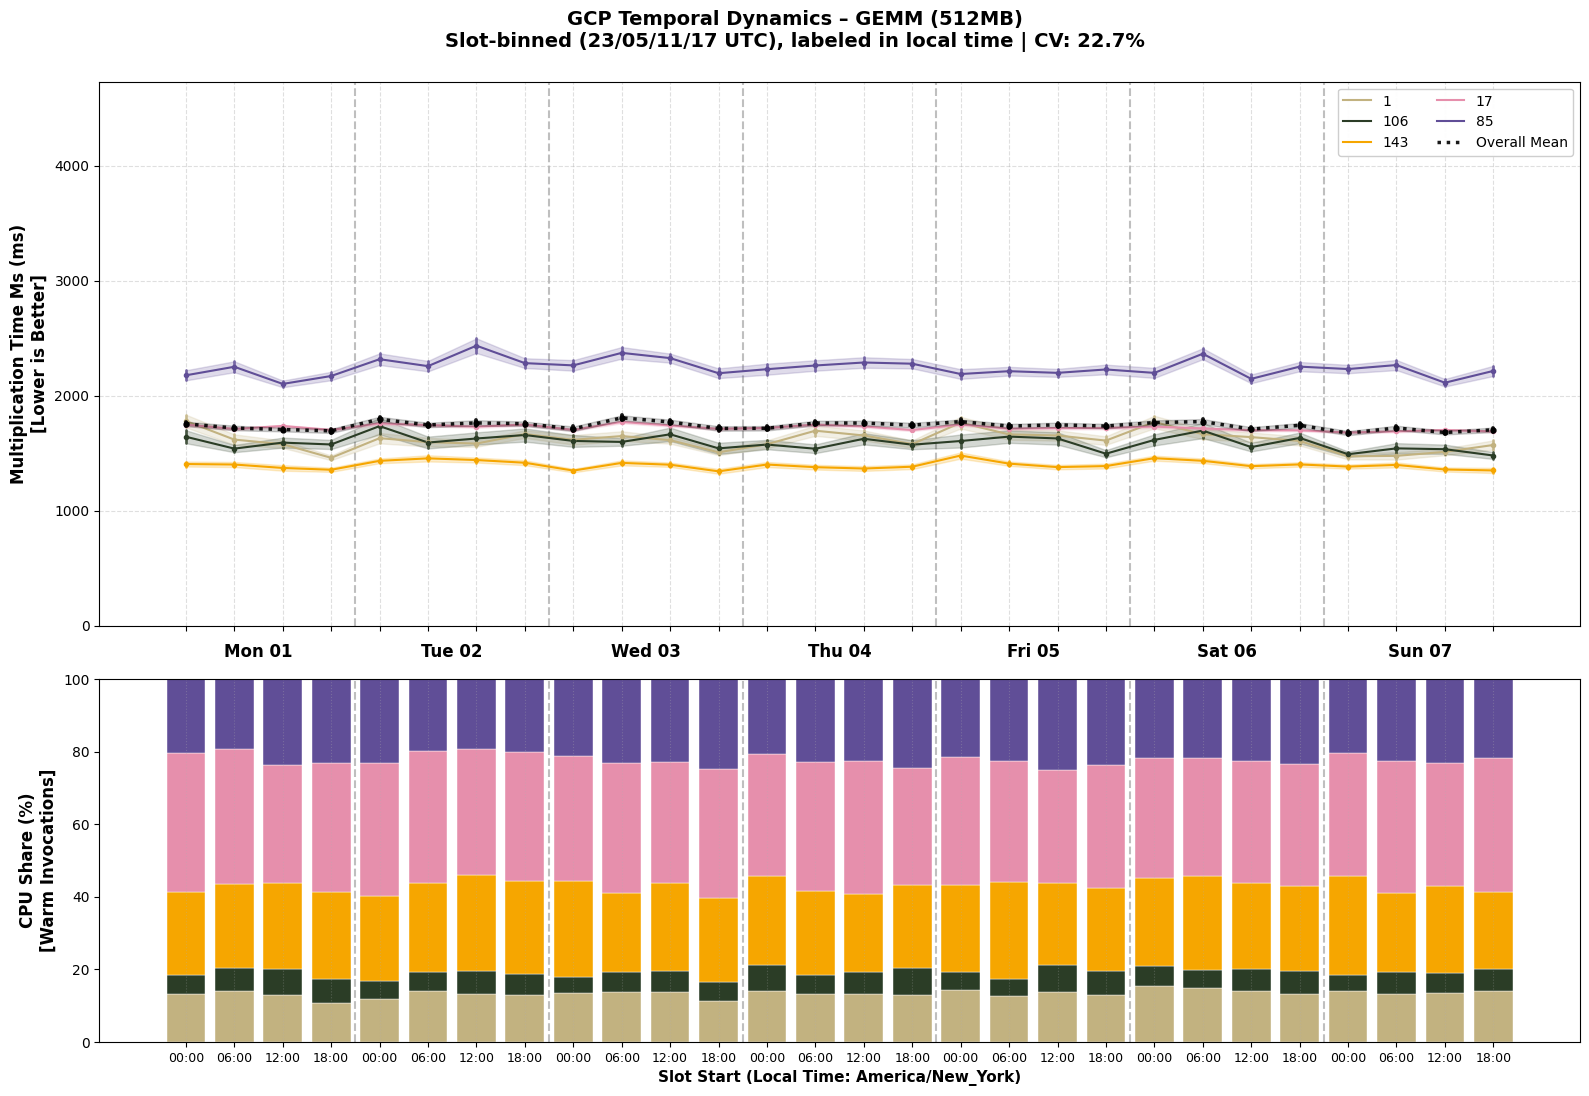

/tmp/ipykernel_11642/4209796247.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return (ts + pd.Timedelta(hours=1)).dt.floor("6H") - pd.Timedelta(hours=1)


Saved to: ../holy/graphs/StageC/gcp/trends/trend_sha256_gcp_512mb.pdf


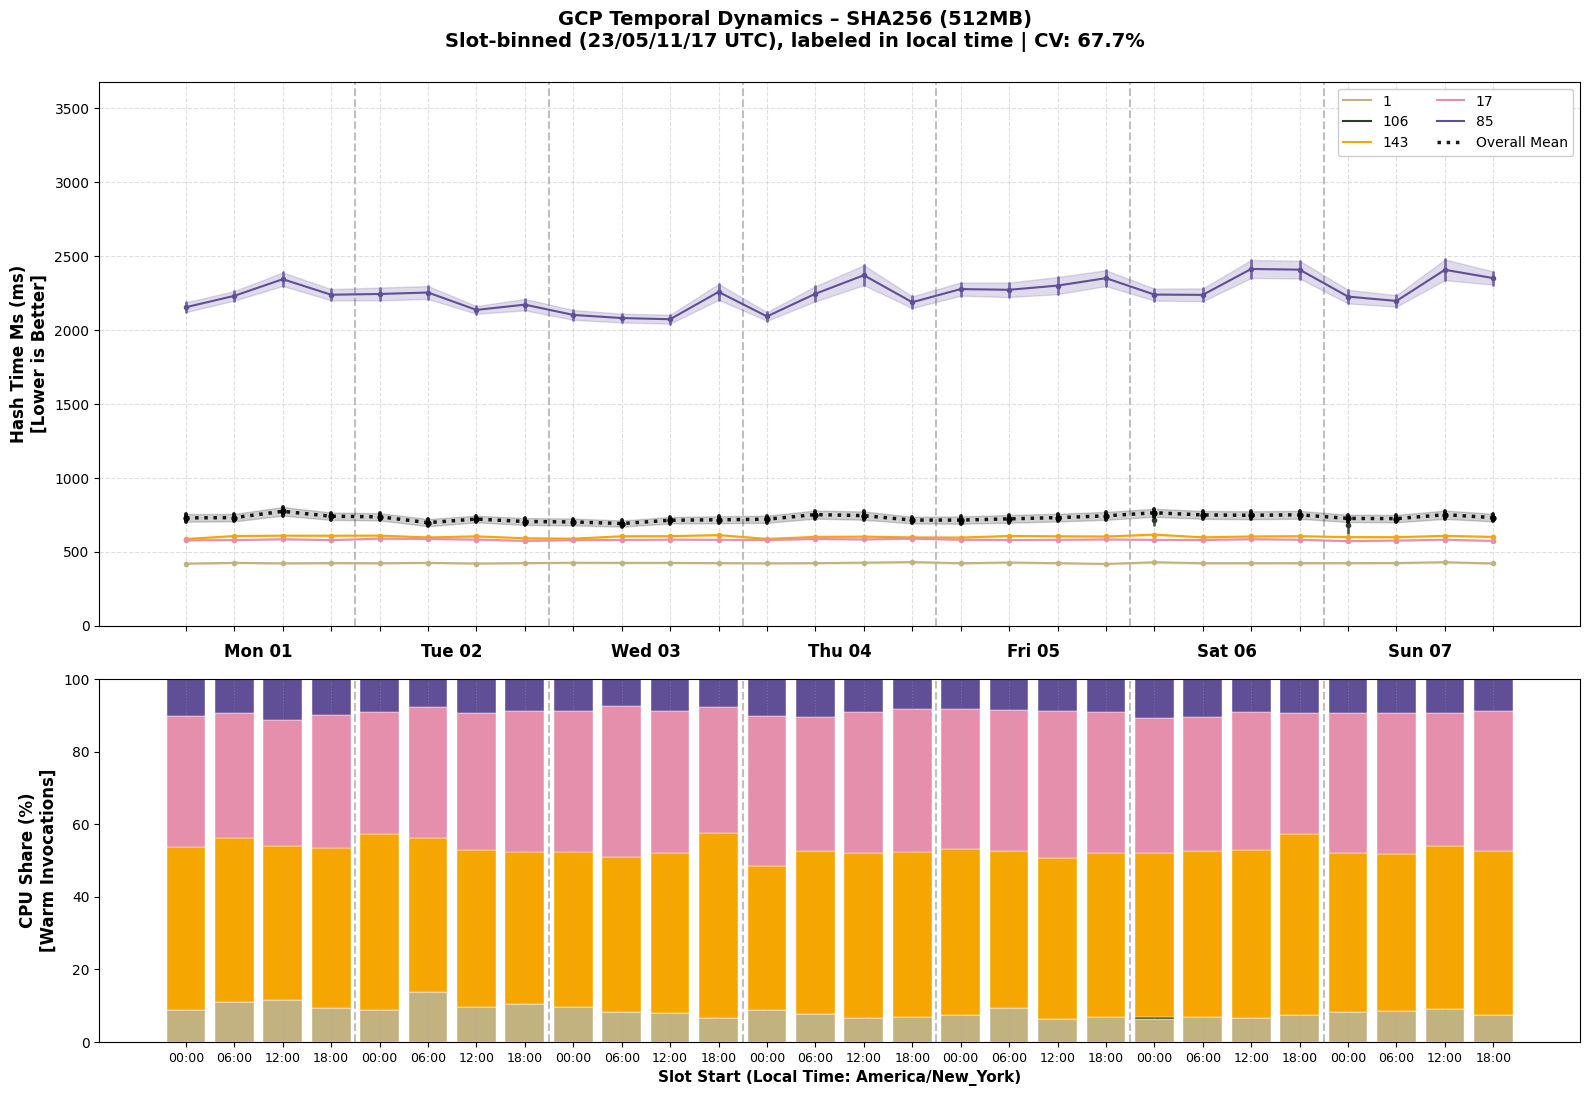

/tmp/ipykernel_11642/4209796247.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return (ts + pd.Timedelta(hours=1)).dt.floor("6H") - pd.Timedelta(hours=1)


Saved to: ../holy/graphs/StageC/gcp/trends/trend_gzip_gcp_512mb.pdf


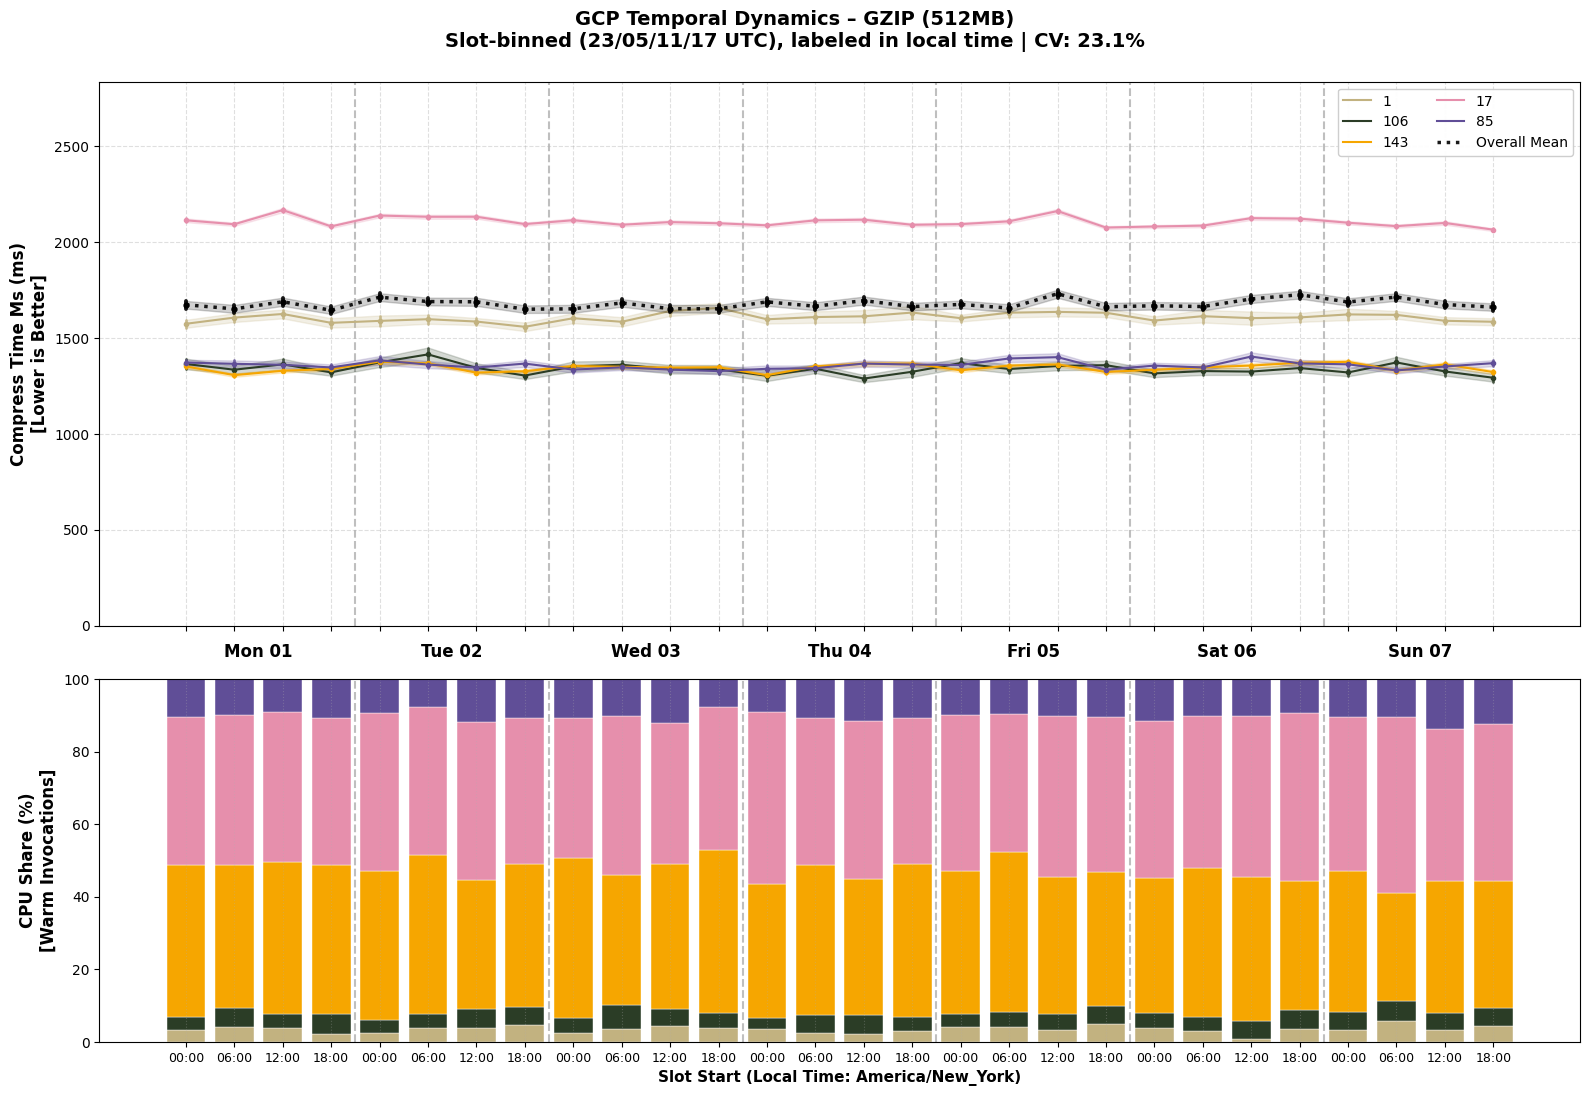

/tmp/ipykernel_11642/4209796247.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return (ts + pd.Timedelta(hours=1)).dt.floor("6H") - pd.Timedelta(hours=1)


Saved to: ../holy/graphs/StageC/gcp/trends/trend_aesCtr_gcp_512mb.pdf


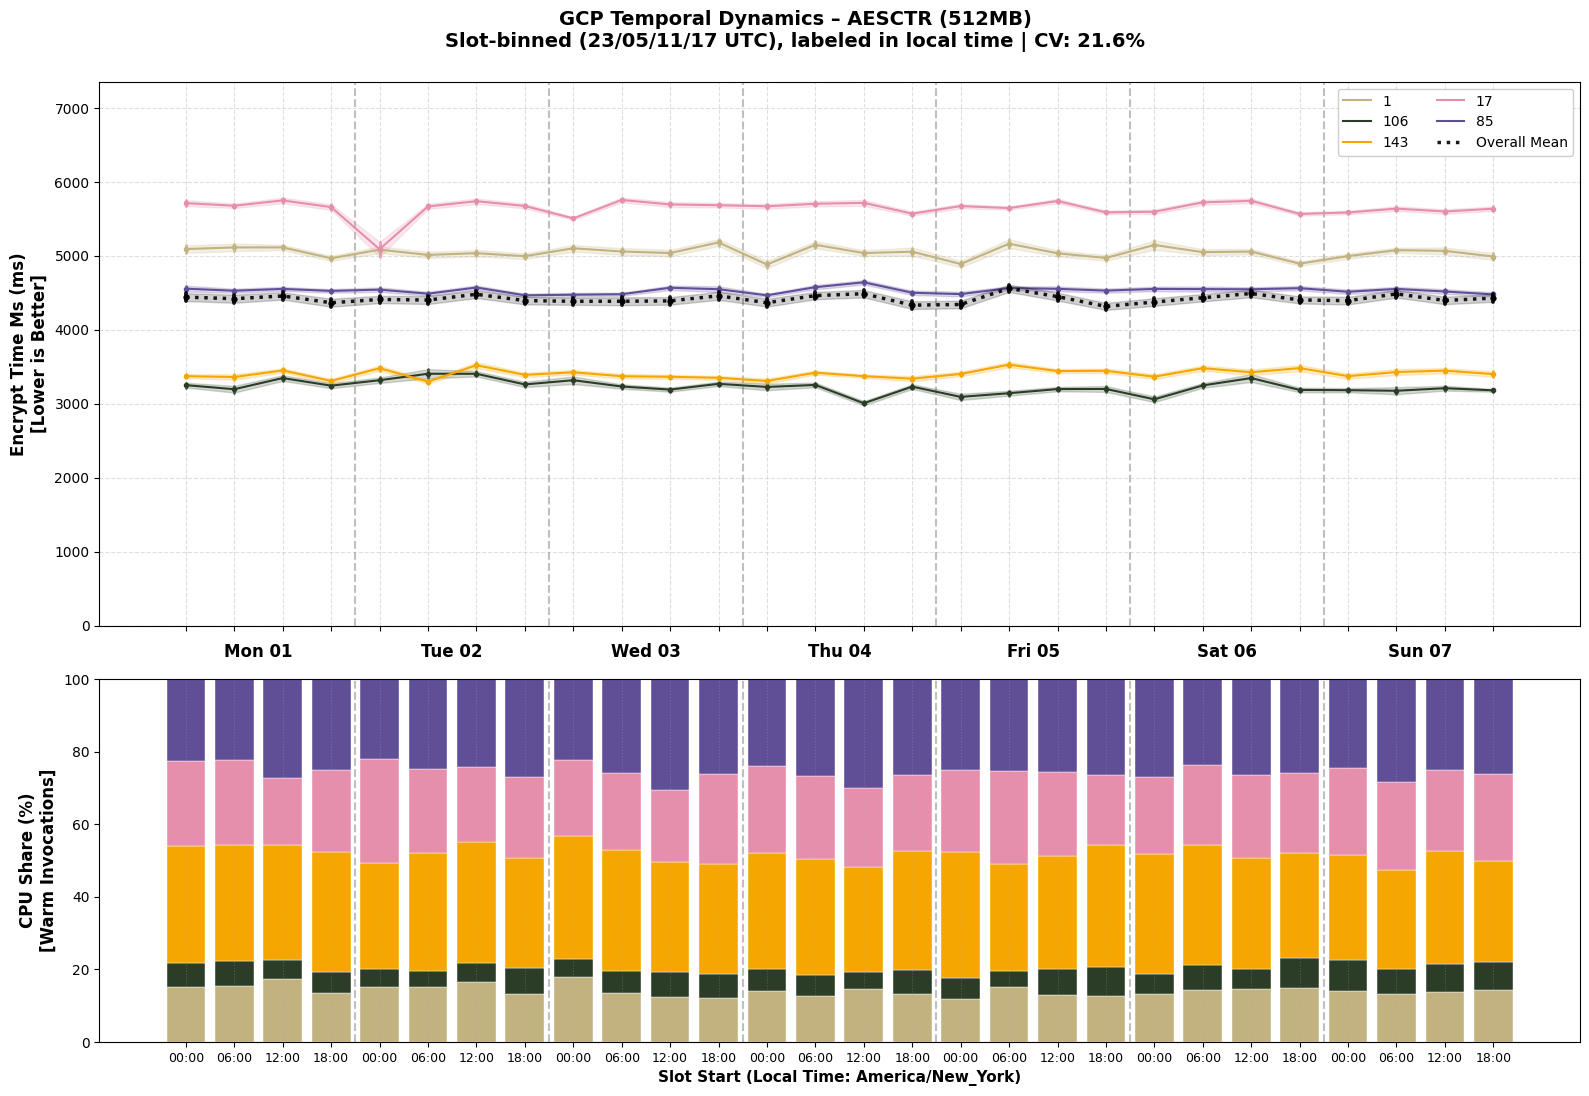

/tmp/ipykernel_11642/4209796247.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return (ts + pd.Timedelta(hours=1)).dt.floor("6H") - pd.Timedelta(hours=1)


Saved to: ../holy/graphs/StageC/gcp/trends/trend_json_gcp_512mb.pdf


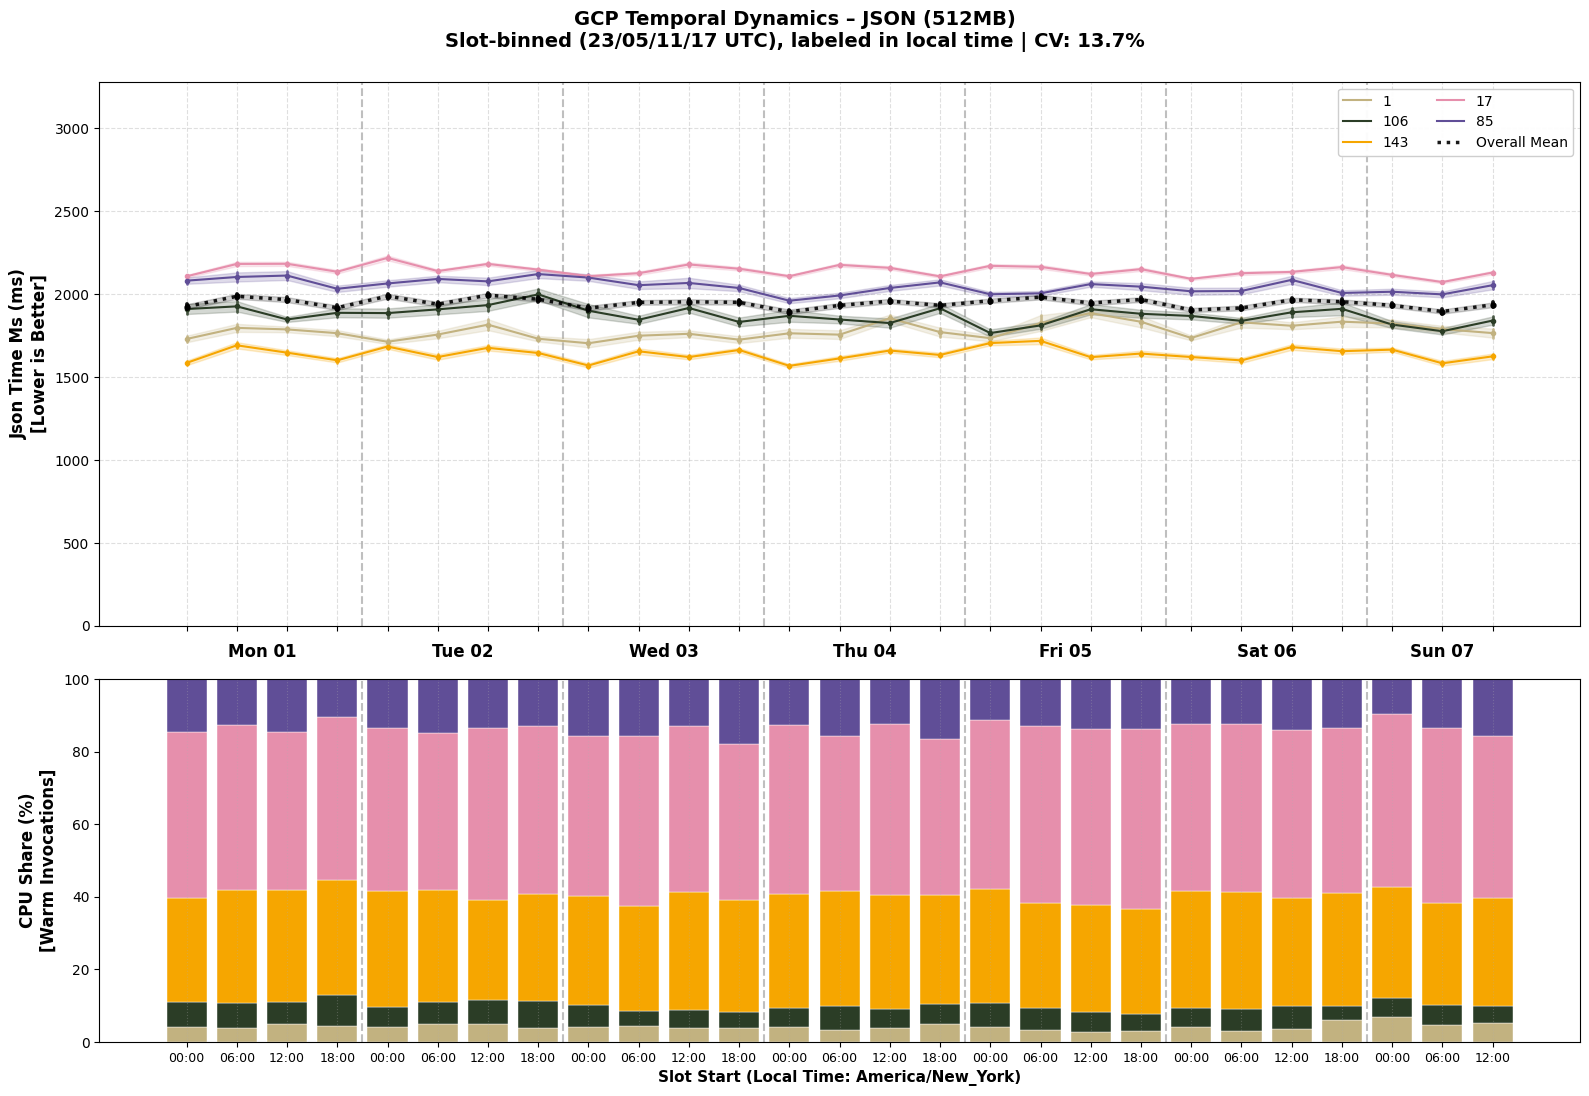

In [24]:
# aws: Second week only (Nov 10-17)
# plot_experiment_trend_robust(df, "azure", memory_size=512, benchmark="gemm",  save_dir="../holy/graphs/StageC")

# # AWS: First week (Nov 3-10)
# plot_experiment_trend_robust(df, "aws", memory_size=512, benchmark="gemm", save_dir="../holy/graphs/StageC")
# # alibaba: First week 
# plot_experiment_trend_robust(df, "alibaba", memory_size=512, benchmark="gemm", 
#                              save_dir="../holy/graphs/StageC")

# Alibaba: Specific time range
plot_experiment_trend_robust(df, "gcp", memory_size=512, benchmark="gemm", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "gcp", memory_size=512, benchmark="sha256", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "gcp", memory_size=512, benchmark="gzip", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "gcp", memory_size=512, benchmark="aesCtr", 
                             save_dir="../holy/graphs/StageC")

plot_experiment_trend_robust(df, "gcp", memory_size=512, benchmark="json", 
                             save_dir="../holy/graphs/StageC")

In [30]:
import pandas as pd
import numpy as np

from helpers.benchmark import filter_cpu_data, metric_for_benchmark


def _slot_bin_stage_c_utc(ts: pd.Series) -> pd.Series:
    """
    Stage C slots are at 23, 05, 11, 17 UTC.
    Bin ANY timestamp into the correct slot.
    """
    ts = pd.to_datetime(ts, utc=True)
    return (ts + pd.Timedelta(hours=1)).dt.floor("6H") - pd.Timedelta(hours=1)


def _provider_local_tz(provider: str) -> str:
    return "Europe/Berlin" if provider == "azure" else "America/New_York"


def _cv_pct(x: pd.Series) -> float:
    x = pd.to_numeric(x, errors="coerce").dropna()
    if len(x) < 2:
        return np.nan
    m = x.mean()
    s = x.std(ddof=1)
    return (s / m * 100.0) if m else np.nan


def variance_table_overall_and_per_slot(
    df: pd.DataFrame,
    provider: str,
    memory_size: int = 512,
    benchmark: str = "gemm",
):
    """
    Returns a table with:
      - OVERALL variance (CV%) across all warm invocations
      - variance within each Stage-C timestamp/slot
    Uses your filter_cpu_data (so outlier filter remains active if enabled there).
    """

    # 1) Filter (warm-only etc. as in your helper)
    df_f = filter_cpu_data(
        df=df,
        provider=provider,
        memory_size=memory_size,
        benchmark=benchmark,
        group_on_timestamp=True,
        remove_cold=True,
        region=None,
    ).copy()

    if df_f.empty:
        print(f"No data after filtering for {provider} {memory_size}MB {benchmark}")
        return pd.DataFrame()

    # 2) Pick metric
    metric = metric_for_benchmark(benchmark)
    if metric not in df_f.columns:
        metric = "runtime_ms"

    df_f = df_f.dropna(subset=["timestamp", metric]).copy()
    df_f["timestamp"] = pd.to_datetime(df_f["timestamp"], utc=True)

    # 3) Slot binning + local label
    df_f["slot_utc"] = _slot_bin_stage_c_utc(df_f["timestamp"])
    tz = _provider_local_tz(provider)
    df_f["slot_local"] = df_f["slot_utc"].dt.tz_convert(tz)

    # 4) Per-slot stats
    g = df_f.groupby("slot_utc")[metric]
    per_slot = pd.DataFrame({
        "n": g.count(),
        "mean_ms": g.mean(),
        "std_ms": g.std(ddof=1),
        "cv_pct": g.apply(_cv_pct),
    })

    # Add pretty local label column
    slot_local = (
        df_f.drop_duplicates("slot_utc")
           .set_index("slot_utc")["slot_local"]
           .reindex(per_slot.index)
    )
    per_slot.insert(0, "slot_local", slot_local.dt.strftime("%a %Y-%m-%d %H:%M"))
    per_slot = per_slot.reset_index(drop=True)

    # 5) Overall stats row
    overall = pd.Series({
        "slot_local": "OVERALL",
        "n": int(df_f[metric].count()),
        "mean_ms": float(df_f[metric].mean()),
        "std_ms": float(df_f[metric].std(ddof=1)),
        "cv_pct": float(_cv_pct(df_f[metric])),
    })

    out = pd.concat([overall.to_frame().T, per_slot], ignore_index=True)

    # Round for readability
    out["mean_ms"] = out["mean_ms"].astype(float).round(2)
    out["std_ms"]  = out["std_ms"].astype(float).round(2)
    out["cv_pct"]  = out["cv_pct"].astype(float).round(2)

    return out


# --- Example call ---
table = variance_table_overall_and_per_slot(df, provider="alibaba", memory_size=512, benchmark="gemm")
display(table)


/tmp/ipykernel_11642/1346475005.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return (ts + pd.Timedelta(hours=1)).dt.floor("6H") - pd.Timedelta(hours=1)


,slot_local,n,mean_ms,std_ms,cv_pct
0,OVERALL,36714,2950.26,879.41,29.81
1,Mon 2025-12-01 00:00,1251,3423.86,971.04,28.36
2,Mon 2025-12-01 06:00,1389,3552.90,898.67,25.29
3,Mon 2025-12-01 12:00,1269,3104.68,820.29,26.42
4,Mon 2025-12-01 18:00,1257,3850.05,985.19,25.59
5,Tue 2025-12-02 00:00,1404,2788.25,733.66,26.31
6,Tue 2025-12-02 06:00,1281,2491.49,651.69,26.16
7,Tue 2025-12-02 12:00,1242,2878.12,751.37,26.11
8,Tue 2025-12-02 18:00,1356,3015.02,846.62,28.08
9,Wed 2025-12-03 00:00,1371,2558.84,551.85,21.57
